In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
N_FFT = 1024

# def reduce_noise(signal, sr=22050, n_fft=N_FFT, hop_length=512):
#     stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
#     magnitude, phase = librosa.magphase(stft)
#     power_spectrum = magnitude**2
    
#     median_power = np.median(power_spectrum, axis=1)
#     median_power_db = librosa.power_to_db(median_power, ref=np.max)
#     mask_gain_dB = np.min(median_power_db) - median_power_db
#     mask_gain = librosa.db_to_amplitude(mask_gain_dB)
    
#     power_spectrum_clean = power_spectrum * mask_gain[:, np.newaxis]
#     stft_clean = magnitude * phase
#     signal_clean = librosa.istft(stft_clean, hop_length=hop_length)
#     return signal_clean

In [3]:
# def remove_silence(signal, sr=22050, top_db=20):
#     non_silent_intervals = librosa.effects.split(signal, top_db=top_db)
#     non_silent_signal = np.concatenate([signal[start:end] for start, end in non_silent_intervals])
#     return non_silent_signal

In [4]:
def extract_mel_spectrogram(signal, sr=22050, n_fft=N_FFT, n_mels=128, target_size=(128, 128)):
    if len(signal) < n_fft:
        signal = np.pad(signal, (0, n_fft - len(signal)), mode='constant')  # Padding untuk sinyal pendek
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram_db.shape[1] < target_size[1]:
        padding = target_size[1] - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, padding)), mode='constant')
    elif mel_spectrogram_db.shape[1] > target_size[1]:
        mel_spectrogram_db = mel_spectrogram_db[:, :target_size[1]]
    return mel_spectrogram_db
print(f"Using n_fft={N_FFT} for mel spectrogram calculation.")

Using n_fft=1024 for mel spectrogram calculation.


In [5]:
def detect_pitch_yin(signal, sr=22050, fmin=50, fmax=500, target_size=128):
    if len(signal) < N_FFT:
        signal = np.pad(signal, (0, N_FFT - len(signal)), mode='constant')  # Padding untuk sinyal pendek
    pitches, magnitudes = librosa.core.pitch.piptrack(y=signal, sr=sr, n_fft=N_FFT, fmin=fmin, fmax=fmax)
    pitch_values = [pitches[magnitudes[:, t].argmax(), t] for t in range(pitches.shape[1])]
    pitch_values = np.array(pitch_values)
    if pitch_values.max() != pitch_values.min():
        pitch_values = (pitch_values - pitch_values.min()) / (pitch_values.max() - pitch_values.min())
    else:
        pitch_values = np.zeros(target_size)
    if len(pitch_values) < target_size:
        padding = target_size - len(pitch_values)
        pitch_values = np.pad(pitch_values, (0, padding), mode='constant')
    elif len(pitch_values) > target_size:
        pitch_values = pitch_values[:target_size]
    return pitch_values

In [6]:
def process_audio_by_transient(file_path, sr=22050):
    signal, sr = librosa.load(file_path, sr=sr)
    transients = librosa.onset.onset_detect(y=signal, sr=sr, units='samples')
    transients = np.concatenate([[0], transients, [len(signal)]])
    segments = []
    segment_times = []
    for i in range(len(transients) - 1):
        start = transients[i]
        end = transients[i + 1]
        segment = signal[start:end]
        if len(segment) >= N_FFT:  # Filter segmen yang terlalu pendek
            mel_spectrogram = extract_mel_spectrogram(segment, sr)
            pitch_values = detect_pitch_yin(segment, sr)
            segments.append((mel_spectrogram, pitch_values))
            segment_times.append(start / sr)  # Convert sample index to time
    return segments, segment_times

In [7]:
# Loading the dataset with enhanced preprocessing
def load_dataset_with_transient(dataset_dir, target_size=(128, 128)):
    X_mel = []
    X_pitch = []
    y = []
    labels = ['Do', 'Re', 'Mi', 'Fa', 'Sol', 'La', 'Si']
    label_index_map = {label: idx for idx, label in enumerate(labels)}
    for label in labels:
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(label_dir, file_name)
                    segments, _ = process_audio_by_transient(file_path, sr=22050)
                    for mel_spectrogram, pitch_values in segments:
                        if mel_spectrogram is not None and pitch_values is not None:
                            X_mel.append(mel_spectrogram)
                            X_pitch.append(pitch_values)
                            label_vector = np.zeros(len(labels))
                            label_vector[label_index_map[label]] = 1
                            y.append(label_vector)
    X_mel = np.array(X_mel)
    X_pitch = np.array(X_pitch)
    y = np.array(y)
    return X_mel, X_pitch, y, labels

In [8]:
# Load dataset
dataset_dir = 'Dataset'
X_mel, X_pitch, y, labels = load_dataset_with_transient(dataset_dir, target_size=(128, 128))

# Add channel dimension to mel spectrograms
X_mel = X_mel[..., np.newaxis]

# Split dataset into training and testing sets
X_mel_train, X_mel_test, X_pitch_train, X_pitch_test, y_train, y_test = train_test_split(X_mel, X_pitch, y, test_size=0.2, random_state=42)

In [9]:
# Define the CNN model
input_mel = layers.Input(shape=(128, 128, 1))
input_pitch = layers.Input(shape=(128,))

# Memasukkan lapisan convolution untuk feature extraction
x_mel = Conv2D(32, (3, 3), activation='relu')(input_mel)
x_mel = BatchNormalization()(x_mel)
x_mel = Dropout(0.5)(x_mel)  # Menambahkan dropout setelah batch normalization
x_mel = MaxPooling2D((2, 2))(x_mel)

x_mel = Conv2D(64, (3, 3), activation='relu')(x_mel)
x_mel = BatchNormalization()(x_mel)
x_mel = Dropout(0.5)(x_mel)
x_mel = MaxPooling2D((2, 2))(x_mel)

x_mel = Conv2D(128, (3, 3), activation='relu')(x_mel)
x_mel = BatchNormalization()(x_mel)
x_mel = Dropout(0.5)(x_mel)
x_mel = MaxPooling2D((2, 2))(x_mel)
x_mel = layers.Flatten()(x_mel)

x_combined = layers.concatenate([x_mel, input_pitch])

x_combined = layers.Dense(256, activation='relu')(x_combined)
x_combined = Dropout(0.5)(x_combined)

output = layers.Dense(len(labels), activation='sigmoid')(x_combined)

model = models.Model(inputs=[input_mel, input_pitch], outputs=output)

In [10]:
# Set learning rate dan optimizer
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit([X_mel_train, X_pitch_train], y_train, epochs=30, validation_data=([X_mel_test, X_pitch_test], y_test))

Epoch 1/30
 87/379 [=====>........................] - ETA: 3:07 - loss: 0.8848 - accuracy: 0.1976

KeyboardInterrupt: 

In [ ]:
# Save model
model.save('model.h5')
print("Model saved.")

Model saved.


c:\anaconda3\envs\Melody\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

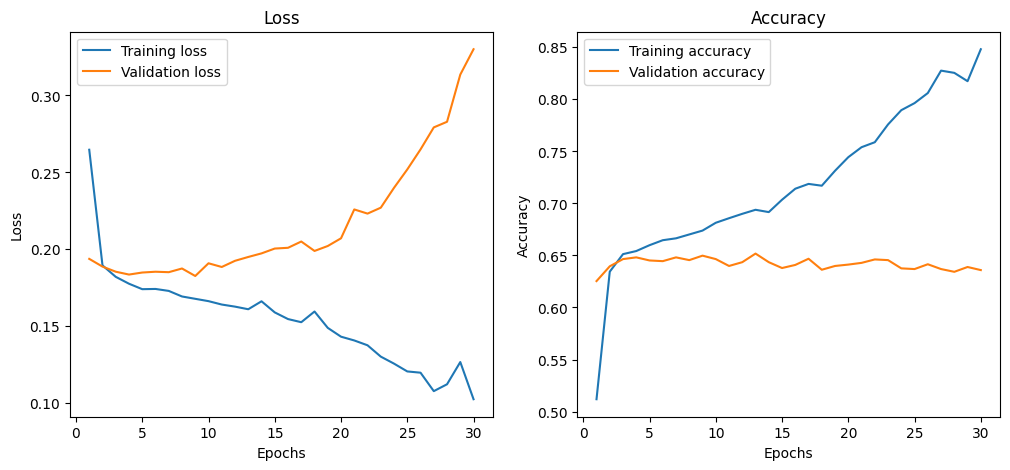

In [ ]:
# Plot loss and accuracy
def plot_loss_accuracy(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plotting loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_loss_accuracy(history)


95/95 [==============================] - 5s 55ms/step
              precision    recall  f1-score   support

          Do       0.70      0.57      0.63       500
          Re       0.62      0.61      0.61       525
          Mi       0.49      0.62      0.55       432
          Fa       0.61      0.64      0.62       420
         Sol       0.79      0.63      0.70       425
          La       0.70      0.76      0.73       316
          Si       0.64      0.68      0.66       409

    accuracy                           0.64      3027
   macro avg       0.65      0.64      0.64      3027
weighted avg       0.65      0.64      0.64      3027



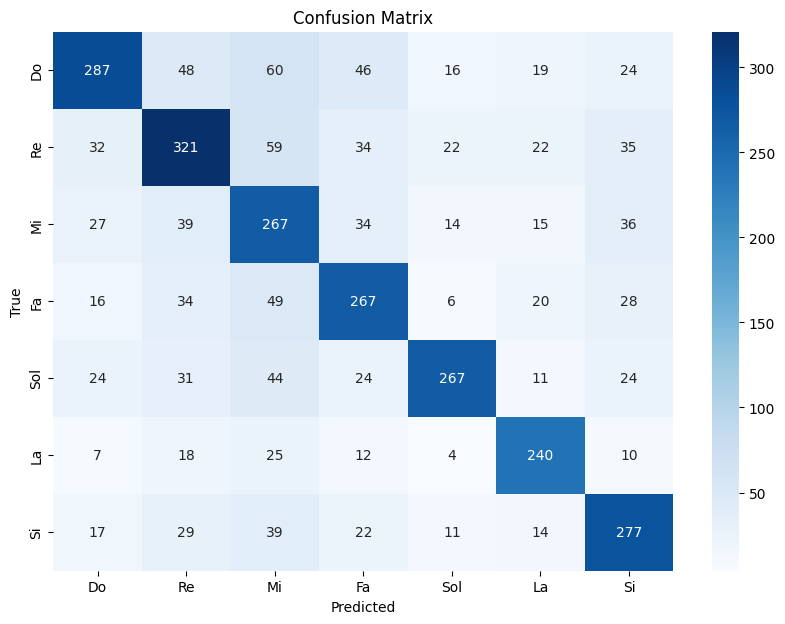

In [ ]:
# Get predictions
y_pred = model.predict([X_mel_test, X_pitch_test])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true_labels, y_pred_labels, labels)


Saved segments\segment1.wav
1/1 [==============================] - 0s 36ms/step


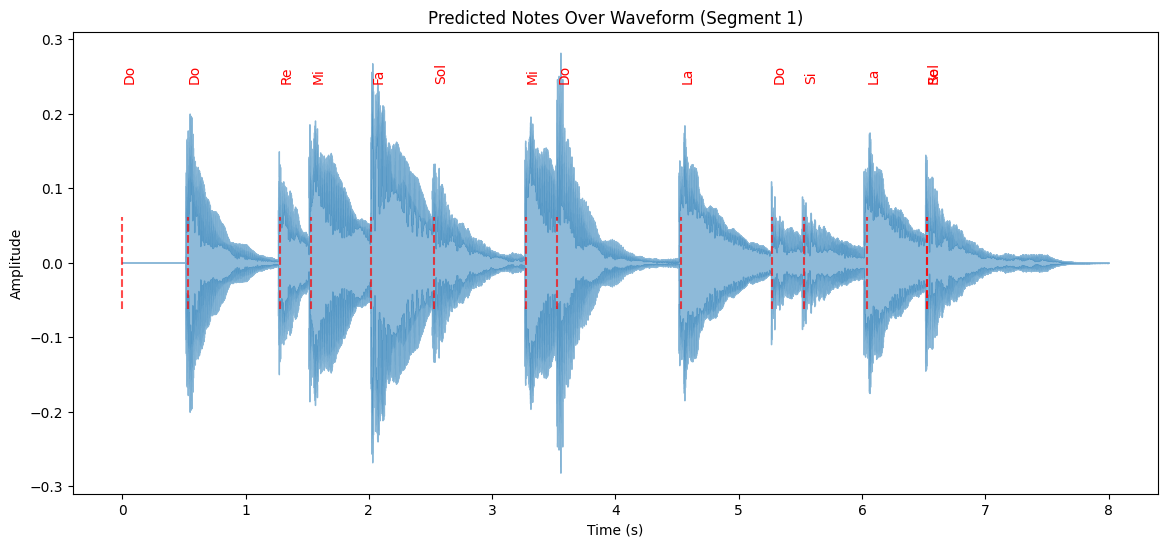

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from tensorflow.keras.models import load_model
import soundfile as sf

N_FFT = 1024

def extract_mel_spectrogram(signal, sr=22050, n_fft=N_FFT, n_mels=128, target_size=(128, 128)):
    if len(signal) < n_fft:
        signal = np.pad(signal, (0, n_fft - len(signal)), mode='constant')  # Padding untuk sinyal pendek
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram_db.shape[1] < target_size[1]:
        padding = target_size[1] - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, padding)), mode='constant')
    elif mel_spectrogram_db.shape[1] > target_size[1]:
        mel_spectrogram_db = mel_spectrogram_db[:, :target_size[1]]
    return mel_spectrogram_db

def detect_pitch_yin(signal, sr=22050, fmin=50, fmax=500, target_size=128):
    if len(signal) < N_FFT:
        signal = np.pad(signal, (0, N_FFT - len(signal)), mode='constant')  # Padding untuk sinyal pendek
    pitches, magnitudes = librosa.core.pitch.piptrack(y=signal, sr=sr, n_fft=N_FFT, fmin=fmin, fmax=fmax)
    pitch_values = [pitches[magnitudes[:, t].argmax(), t] for t in range(pitches.shape[1])]
    pitch_values = np.array(pitch_values)
    if pitch_values.max() != pitch_values.min():
        pitch_values = (pitch_values - pitch_values.min()) / (pitch_values.max() - pitch_values.min())
    else:
        pitch_values = np.zeros(target_size)
    if len(pitch_values) < target_size:
        padding = target_size - len(pitch_values)
        pitch_values = np.pad(pitch_values, (0, padding), mode='constant')
    elif len(pitch_values) > target_size:
        pitch_values = pitch_values[:target_size]
    return pitch_values

def process_audio_segments_by_transient(file_path, sr=22050, segment_duration=10):
    signal, sr = librosa.load(file_path, sr=sr)
    
    segment_length = segment_duration * sr
    num_segments = int(np.ceil(len(signal) / segment_length))
    
    segments = []
    segment_times = []

    for i in range(num_segments):
        start = i * segment_length
        end = min((i + 1) * segment_length, len(signal))
        segment = signal[start:end]

        # Process by transient within each segment
        transients = librosa.onset.onset_detect(y=segment, sr=sr, units='samples')
        transients = np.concatenate([[0], transients, [len(segment)]])

        for j in range(len(transients) - 1):
            t_start = transients[j]
            t_end = transients[j + 1]
            transient_segment = segment[t_start:t_end]
            mel_spectrogram = extract_mel_spectrogram(transient_segment, sr)
            pitch_values = detect_pitch_yin(transient_segment, sr)
            segments.append((mel_spectrogram, pitch_values))
            segment_times.append((start + t_start) / sr)  # Convert sample index to time

    return segments, segment_times

def predict_segments(model, segments, segment_times, threshold=0.3):
    labels = ['Do', 'Re', 'Mi', 'Fa', 'Sol', 'La', 'Si']
    all_predictions = []

    for (mel_spectrogram, pitch_values), start_time in zip(segments, segment_times):
        mel_spectrogram = mel_spectrogram[..., np.newaxis]
        mel_spectrogram = np.expand_dims(mel_spectrogram, axis=0)
        pitch_values = np.expand_dims(pitch_values, axis=0)

        prediction = model.predict([mel_spectrogram, pitch_values])
        for i, val in enumerate(prediction[0]):
            if val > threshold:
                all_predictions.append((labels[i], start_time))

    return all_predictions

def plot_predictions(file_path, predictions, sr=22050, segment_duration=10):
    signal, sr = librosa.load(file_path, sr=sr)
    segment_length = segment_duration * sr
    num_segments = int(np.ceil(len(signal) / segment_length))

    for i in range(num_segments):
        start = i * segment_length
        end = min((i + 1) * segment_length, len(signal))
        segment_signal = signal[start:end]
        segment_predictions = [pred for pred in predictions if start <= pred[1] * sr < end]
        
        plt.figure(figsize=(14, 6))
        librosa.display.waveshow(segment_signal, sr=sr, alpha=0.5)
        for label, time in segment_predictions:
            time_relative = time - start / sr  # Time relative to the segment
            plt.axvline(x=time_relative, ymin=0.4, ymax=0.6, color='r', alpha=0.7, linestyle='--')
            plt.text(time_relative, max(segment_signal) * 1, label, color='r', rotation=90, verticalalignment='bottom')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Predicted Notes Over Waveform (Segment {i+1})")
        plt.show()

def main(model_path, file_path, output_folder='segments', sr=22050, segment_duration=10, threshold=0.3):
    model = load_model(model_path)
    
    # Save audio segments
    save_audio_segments(file_path, output_folder, sr, segment_duration)
    
    # Process and predict each segment by transient
    segments, segment_times = process_audio_segments_by_transient(file_path, sr, segment_duration)
    predictions = predict_segments(model, segments, segment_times, threshold)
    
    # Plot predictions
    plot_predictions(file_path, predictions, sr, segment_duration)

def save_audio_segments(file_path, output_folder, sr=22050, segment_duration=10):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    signal, sr = librosa.load(file_path, sr=sr)
    
    segment_length = segment_duration * sr
    num_segments = int(np.ceil(len(signal) / segment_length))

    for i in range(num_segments):
        start = i * segment_length
        end = min((i + 1) * segment_length, len(signal))
        segment = signal[start:end]
        output_file = os.path.join(output_folder, f'segment{i+1}.wav')
        sf.write(output_file, segment, sr)
        print(f'Saved {output_file}')

# Example usage
model_path = 'model7.h5'
file_path = 'uploads/Melodi1.wav'
main(model_path, file_path)
